+++
title = "Linear elasticity: disc with hole convergence study"
date = "2022-09-15"
author = "Linda Günther, Sophia Einspänner, Robert Habel, Christoph Lehmann and Thomas Nagel"
web_subsection = "small-deformations"
+++

|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|


# Convergence Analysis: Disc with a hole

For many typical engineering problems that need to be solved using numerical techniques, convergence plays a decisive role. It is important to obtain an accurate numerical solution, i.e., to know the mesh refinement level beyond which the results of the numerical analysis do not change significantly, anymore.

In this study the convergence in stress and displacement values for the disc with hole problem are analysed and compared to each other. This study is based on the accomanying Jupyter notebook "Linear_Disc_with_hole.ipynb", which explains the main features of the analytical and numerical solution of the disc with hole problem. For a better access to the solutions used in this document, it is recommended to read through the previously mentioned Jupyter notebook first.

For the evaluation of the stress and displacement convergence, we consider seven steps of mesh refinement, described by an index parameter. The following table lists each refinement index with the corresponding edge length, which is considered representative of the cell size.

$$
\begin{aligned}
&\begin{array}{cccc}
\text {Refinement Index} & \text {Cell Size [cm]} \\
\hline 8 & 1.429 \\
16 & 0.667 \\
24 & 0.435 \\
40 & 0.256 \\
60 & 0.169 \\
80 & 0.127 \\
240 & 0.042 \\
\end{array}
\end{aligned}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Some plot settings
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.color"] = "black"
plt.rcParams["legend.frameon"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["font.size"] = 14
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (8, 6)

In [2]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
# This list contains all parameters for the
# different meshes we create
STUDY_indices = [8, 16, 24, 40, 60, 80, 240]

# With this parameter the length of one axis of the square plate is defined
STUDY_mesh_size = 20

In [4]:
def read_last_timestep_mesh(study_idx):
    # ATTENTION: The finest resolution (240) is rather expensive to simulate.
    #            Therefore it is tracked in git and might be in a different
    #            directory.
    d = "out" if study_idx == 240 else out_dir

    reader = pv.PVDReader(f"{d}/disc_with_hole_idx_is_{study_idx}.pvd")
    reader.set_active_time_point(-1)  # go to last timestep

    return reader.read()[0]


def slice_along_line(mesh, start_point, end_point):
    line = pv.Line(start_point, end_point, resolution=2)
    return mesh.slice_along_line(line)


def get_sigma_polar_components(mesh):
    sig = mesh.point_data["sigma"]

    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    sigs_polar = vec4_to_mat3x3polar(sig, xs, ys)

    sig_rr = sigs_polar[:, 0, 0]
    sig_tt = sigs_polar[:, 1, 1]
    sig_rt = sigs_polar[:, 0, 1]

    return sig_rr, sig_tt, sig_rt


def get_sort_indices_and_distances_by_distance_from_origin_2D(mesh):
    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    dist_from_origin = np.hypot(xs, ys)
    indices_sorted = np.argsort(dist_from_origin)
    dist_sorted = dist_from_origin[indices_sorted]

    return indices_sorted, dist_sorted


def compute_abs_and_rel_stress_error_rr(sigmas_rr_num, rs, theta_degree):
    num_points = sigmas_rr_num.shape[0]
    f_abs_rr = np.zeros(num_points)
    f_rel_rr = np.zeros(num_points)

    for pt_idx in range(num_points):
        r = rs[pt_idx]

        sigma_rr_ana = kirsch_sig_rr(10, r, theta_degree, 2)

        sigma_rr_num = sigmas_rr_num[pt_idx] * 1000

        f_abs_rr[pt_idx] = sigma_rr_num - sigma_rr_ana

        if sigma_rr_ana == 0:
            f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / 1e-2
        else:
            f_rel_rr[pt_idx] = f_abs_rr[pt_idx] / sigma_rr_ana

    return f_abs_rr, f_rel_rr


def compute_abs_and_rel_stress_error_rt(sigmas_rt_num, rs, theta_degree):
    num_points = sigmas_rt_num.shape[0]
    f_abs_rt = np.zeros(num_points)
    f_rel_rt = np.zeros(num_points)

    for pt_idx in range(num_points):
        r = rs[pt_idx]

        sigma_rt_ana = kirsch_sig_rt(10, r, theta_degree, 2)
        sigma_rt_num = sigmas_rt_num[pt_idx] * 1000

        f_abs_rt[pt_idx] = sigma_rt_num - sigma_rt_ana

        if sigma_rt_ana == 0:
            f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / 1e-2
        else:
            f_rel_rt[pt_idx] = f_abs_rt[pt_idx] / sigma_rt_ana

    return f_abs_rt, f_rel_rt


def compute_abs_and_rel_stress_error_tt(sigmas_tt_num, rs, theta_degree):
    num_points = sigmas_tt_num.shape[0]
    f_abs_tt = np.zeros(num_points)
    f_rel_tt = np.zeros(num_points)

    for pt_idx in range(num_points):
        r = rs[pt_idx]

        sigma_tt_ana = kirsch_sig_tt(10, r, theta_degree, 2)
        sigma_tt_num = sigmas_tt_num[pt_idx] * 1000

        f_abs_tt[pt_idx] = sigma_tt_num - sigma_tt_ana

        if sigma_tt_ana == 0:
            f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / 1e-2
        else:
            f_rel_tt[pt_idx] = f_abs_tt[pt_idx] / sigma_tt_ana

    return f_abs_tt, f_rel_tt


def compute_cell_size(_idx, mesh):
    pt1 = (19.999, 0, 0)
    pt2 = (19.999, 20, 0)
    line_mesh = slice_along_line(mesh, pt1, pt2)
    number = (
        line_mesh.points.shape[0] - 1
    )  # number of cells along the right edge of the plate
    return STUDY_mesh_size / number  # height of plate divided by number of cells


def resample_mesh_to_240_resolution(idx):
    mesh_fine = read_last_timestep_mesh(240)
    mesh_coarse = read_last_timestep_mesh(idx)
    return mesh_fine.sample(mesh_coarse)

## Create Gmsh meshes

To generate the meshes and to enable the individual parameters to be adjusted from within this notebook the script "mesh_quarter_of_rectangle_with_hole.py" is used.
For the considered problem the parameter $a$ and $b$ which define the size of the rectangular quarter of the plate are set to a value of $20\, \text{cm}$. The radius of the central hole is controlled by the value of $r$, which is set at $r = 2\, \text{cm}$.

The arguments Nx, Ny, NR and Nr of the script describe the refinement of the mesh and are determined according to each refinement index.

Parameter $R$ describes the area for a further refinement in the vicinity of the hole. This additional refinement is needed for better capturing the stress and strain gradients near the hole. Because the fine resolution of the mesh is only needed in the area around the hole, the size of $R$ is half the size of the plate.

In [5]:
import mesh_quarter_of_rectangle_with_hole

In [6]:
for idx in STUDY_indices:
    """
    a and b seem to be the sizes of the rectangular plate,
    r the hole radius, R an auxiliary radius
    the other parameters control the mesh resolution
    please check that, and maybe document in mesh_quarter_of_rectangle_with_hole.py
    """
    output_file = f"{out_dir}/disc_with_hole_idx_is_{idx}.msh"
    mesh_quarter_of_rectangle_with_hole.run(
        output_file,
        a=STUDY_mesh_size,
        b=STUDY_mesh_size,
        r=2,
        R=0.5 * STUDY_mesh_size,
        Nx=idx,
        Ny=idx,
        NR=idx,
        Nr=idx,
        P=1,
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Circle)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [100%] Meshing curve 15 (Line)
Info    : Done meshing 1D (Wall 0.000830175s, CPU 0.001139s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 80%] Meshing surface 5 (Transfinite)
Info    : Done meshing 2D (Wall 0.00

## Transform to VTU meshes suitable for OGS

In [7]:
for idx in STUDY_indices:
    input_file = f"{out_dir}/disc_with_hole_idx_is_{idx}.msh"
    msh2vtu_out_dir = Path(f"{out_dir}/disc_with_hole_idx_is_{idx}")
    if not msh2vtu_out_dir.exists():
        msh2vtu_out_dir.mkdir(parents=True)
    ! msh2vtu -r --keep_ids -o {out_dir}/disc_with_hole_idx_is_{idx} {input_file}
    %cd {out_dir}/disc_with_hole_idx_is_{idx}
    ! identifySubdomains -f -m disc_with_hole_idx_is_{idx}_domain.vtu -- disc_with_hole_idx_is_{idx}_physical_group_*.vtu
    %cd -

## Visualize the meshes

To get a better sense of cell sizes and the additional refinement around the hole, the meshes of refinement indices 8 and 80 are shown below.

In [8]:
import pyvista as pv

pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

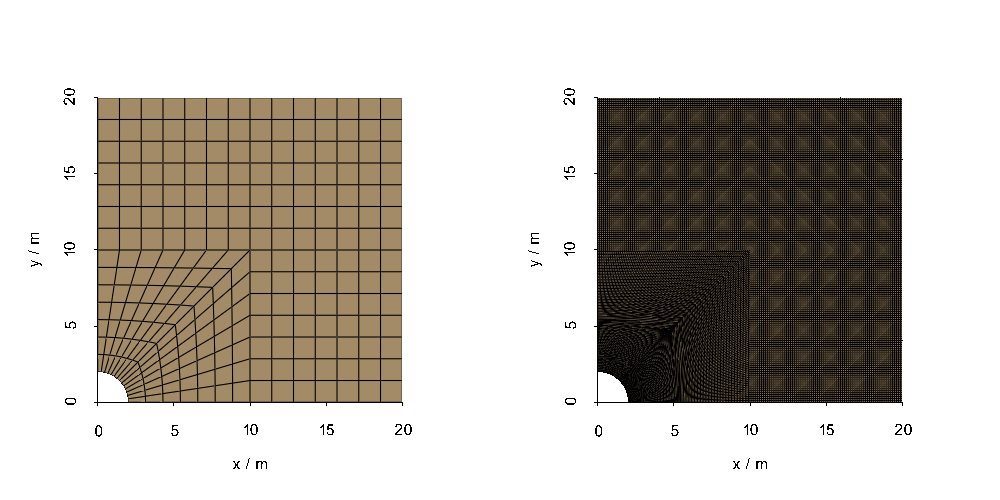

In [9]:
domain_8 = pv.read(
    f"{out_dir}/disc_with_hole_idx_is_8/disc_with_hole_idx_is_8_domain.vtu"
)
domain_80 = pv.read(
    f"{out_dir}/disc_with_hole_idx_is_80/disc_with_hole_idx_is_80_domain.vtu"
)

p = pv.Plotter(shape=(1, 2), border=False)
p.subplot(0, 0)
p.add_mesh(domain_8, show_edges=True, show_scalar_bar=False, color=None, scalars=None)
p.view_xy()
p.show_bounds(ticks="outside", xlabel="x / m", ylabel="y / m")
p.camera.zoom(1.3)

p.subplot(0, 1)
p.add_mesh(domain_80, show_edges=True, show_scalar_bar=False, color=None, scalars=None)
p.view_xy()
p.show_bounds(ticks="outside", xlabel="x / m", ylabel="y / m")
p.camera.zoom(1.3)
p.window_size = [1000, 500]

p.show()

## Run OGS

In [10]:
import shutil

from ogs6py import ogs

In [11]:
# ATTENTION: We exclude the last study index, because its simulation takes
#            too long to be included in the OGS CI pipelines.
for idx in STUDY_indices[:-1]:
    prj_file = f"disc_with_hole_idx_is_{idx}.prj"

    shutil.copy2(prj_file, out_dir)

    prj_path = out_dir / prj_file

    model = ogs.OGS(INPUT_FILE=prj_path, PROJECT_FILE=prj_path)
    model.run_model(
        logfile=f"{out_dir}/out.txt",
        args=f"-o {out_dir} -m {out_dir}/disc_with_hole_idx_is_{idx}",
    )

OGS finished with project file out/disc_with_hole_idx_is_8.prj.
Execution took 0.13451766967773438 s
OGS finished with project file out/disc_with_hole_idx_is_16.prj.
Execution took 0.25728845596313477 s
OGS finished with project file out/disc_with_hole_idx_is_24.prj.
Execution took 0.6107831001281738 s
OGS finished with project file out/disc_with_hole_idx_is_40.prj.
Execution took 1.8409309387207031 s
OGS finished with project file out/disc_with_hole_idx_is_60.prj.
Execution took 6.817595958709717 s
OGS finished with project file out/disc_with_hole_idx_is_80.prj.
Execution took 17.835182428359985 s


## Error Analysis

### Comparison with analytical solution

In this section we compare the numerical solution for the different refinement levels to Kirsch's analytical solution.
We show plots of the radial, tangential and shear stress distribution along the x-axis.
Additionally, the absolute error of each refinement level to the analytical solution is plotted for better interpretation of variations.

The plots show that–for the considered axis–the stress distribution around the hole converges to Kirsch´s solution with decreasing size of the mesh cells.
This decrease of the extrapolation errors can also be seen in the plots for the absolute error.
Especially in the region close to the hole the error values for finer meshes shrink more and more.

Another effect that is particularly visible in the plots of $\sigma_{rr}$ and $\sigma_{\theta\theta}$ along the x-axis is an increasing convergence of the solutions for each refinement step to the solution for the finest mesh at the outer boundaries.
The results of the numerical solution therefore do not converge against the Kirsch's solution, but against the numerical solution itself for very fine meshes.
This discrepancy is caused by the finite size of the plate in the numerical solution: Kirsch's analytical solution assumes an infinite plate.

For this reason, an error analysis against the analytical solution does not make sense. Instead, the individual numerical solutions are compared with a "pseudo" analytical solution. For this purpose, a numerical result with extremely fine mesh resolution (refinement index = 240) is generated.

In [12]:
def kirsch_sig_rr(sig, r, theta, a):
    return (
        0.5
        * sig
        * (
            (1 - a**2 / r**2)
            + (1 + 3 * np.power(a, 4) / np.power(r, 4) - 4 * a**2 / r**2)
            * np.cos(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )


def kirsch_sig_tt(sig, r, theta, a):
    return (
        0.5
        * sig
        * (
            (1 + a**2 / r**2)
            - (1 + 3 * np.power(a, 4) / np.power(r, 4))
            * np.cos(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )


def kirsch_sig_rt(sig, r, theta, a):
    return (
        -0.5
        * sig
        * (
            (1 - 3 * np.power(a, 4) / np.power(r, 4) + 2 * a**2 / r**2)
            * np.sin(2 * np.pi * theta / 180)
        )
        * np.heaviside(r + 1e-7 - a, 1)
    )

In [13]:
def vec4_to_mat3x3cart(vec4):
    m = np.zeros((3, 3))
    m[0, 0] = vec4[0]
    m[1, 1] = vec4[1]
    m[2, 2] = vec4[2]
    m[0, 1] = vec4[3]
    m[1, 0] = vec4[3]

    return np.matrix(m)


def vec4_to_mat3x3cart_multi(vec4):
    assert vec4.shape[1] == 4

    n_pts = vec4.shape[0]

    m = np.zeros((n_pts, 3, 3))
    m[:, 0, 0] = vec4[:, 0]
    m[:, 1, 1] = vec4[:, 1]
    m[:, 2, 2] = vec4[:, 2]
    m[:, 0, 1] = vec4[:, 3]
    m[:, 1, 0] = vec4[:, 3]

    return m


def vec4_to_mat3x3polar_single(vec4, xs, ys):
    m_cart = vec4_to_mat3x3cart(vec4)

    theta = np.arctan2(ys, xs)

    rot = np.matrix(np.eye(3))
    rot[0, 0] = np.cos(theta)
    rot[0, 1] = -np.sin(theta)
    rot[1, 0] = np.sin(theta)
    rot[1, 1] = np.cos(theta)

    return rot.T * m_cart * rot


def vec4_to_mat3x3polar_multi(vecs4, xs, ys):
    """Convert 4-vectors (Kelvin vector in 2D) to 3x3 matrices in polar coordinates at multiple points at once.

    Parameters
    ----------
    vecs4:
        NumPy array of 4-vectors, dimensions: (N x 4)
    xs:
        NumPy array of x coordinates, length: N
    ys:
        NumPy array of y coordinates, length: N

    Returns
    -------
    A Numpy array of the symmetric matrices corresponding to the 4-vectors, dimensions: (N x 3 x 3)
    """

    n_pts = vecs4.shape[0]
    assert n_pts == xs.shape[0]
    assert n_pts == ys.shape[0]
    assert vecs4.shape[1] == 4

    m_carts = vec4_to_mat3x3cart_multi(vecs4)  # vecs4 converted to symmetric matrices

    thetas = np.arctan2(ys, xs)

    rots = np.zeros((n_pts, 3, 3))  # rotation matrices at each point
    rots[:, 0, 0] = np.cos(thetas)
    rots[:, 0, 1] = -np.sin(thetas)
    rots[:, 1, 0] = np.sin(thetas)
    rots[:, 1, 1] = np.cos(thetas)
    rots[:, 2, 2] = 1

    # rot.T * m_cart * rot for each point
    m_polars = np.einsum("...ji,...jk,...kl", rots, m_carts, rots)

    assert m_polars.shape[0] == n_pts
    assert m_polars.shape[1] == 3
    assert m_polars.shape[2] == 3

    return m_polars


def vec4_to_mat3x3polar(vec4, xs, ys):
    if len(vec4.shape) == 1:
        # only a single 4-vector will be converted
        return vec4_to_mat3x3polar_single(vec4, xs, ys)
    return vec4_to_mat3x3polar_multi(vec4, xs, ys)

In [14]:
# Here we'll collect all simulation results
# accessible via their idx value
# We'll be able to reuse/read them many times
STUDY_num_result_meshes_by_index = {}


def read_simulation_result_meshes():
    for idx in STUDY_indices:
        mesh = read_last_timestep_mesh(idx)
        STUDY_num_result_meshes_by_index[idx] = mesh


read_simulation_result_meshes()

In [15]:
STUDY_num_result_xaxis_meshes_by_index = {}


def compute_xaxis_meshes():
    for idx in STUDY_indices:
        mesh = STUDY_num_result_meshes_by_index[idx]
        pt1 = (0, 1e-6, 0)
        pt2 = (10, 1e-6, 0)
        line_mesh = slice_along_line(mesh, pt1, pt2)

        STUDY_num_result_xaxis_meshes_by_index[idx] = line_mesh


compute_xaxis_meshes()

In [16]:
STUDY_num_result_yaxis_meshes_by_index = {}


def compute_yaxis_meshes():
    for idx in STUDY_indices:
        mesh = STUDY_num_result_meshes_by_index[idx]
        pt1 = (1e-6, 0, 0)
        pt2 = (1e-6, 10, 0)
        line_mesh = slice_along_line(mesh, pt1, pt2)

        STUDY_num_result_yaxis_meshes_by_index[idx] = line_mesh


compute_yaxis_meshes()

In [17]:
STUDY_num_result_diagonal_meshes_by_index = {}


def compute_diagonal_meshes():
    for idx in STUDY_indices:
        mesh = STUDY_num_result_meshes_by_index[idx]
        pt1 = (1e-6, 1e-6, 0)
        pt2 = (28.28, 28.28, 0)
        line_mesh = slice_along_line(mesh, pt1, pt2)

        STUDY_num_result_diagonal_meshes_by_index[idx] = line_mesh


compute_diagonal_meshes()

### Stress distribution along the x-axis

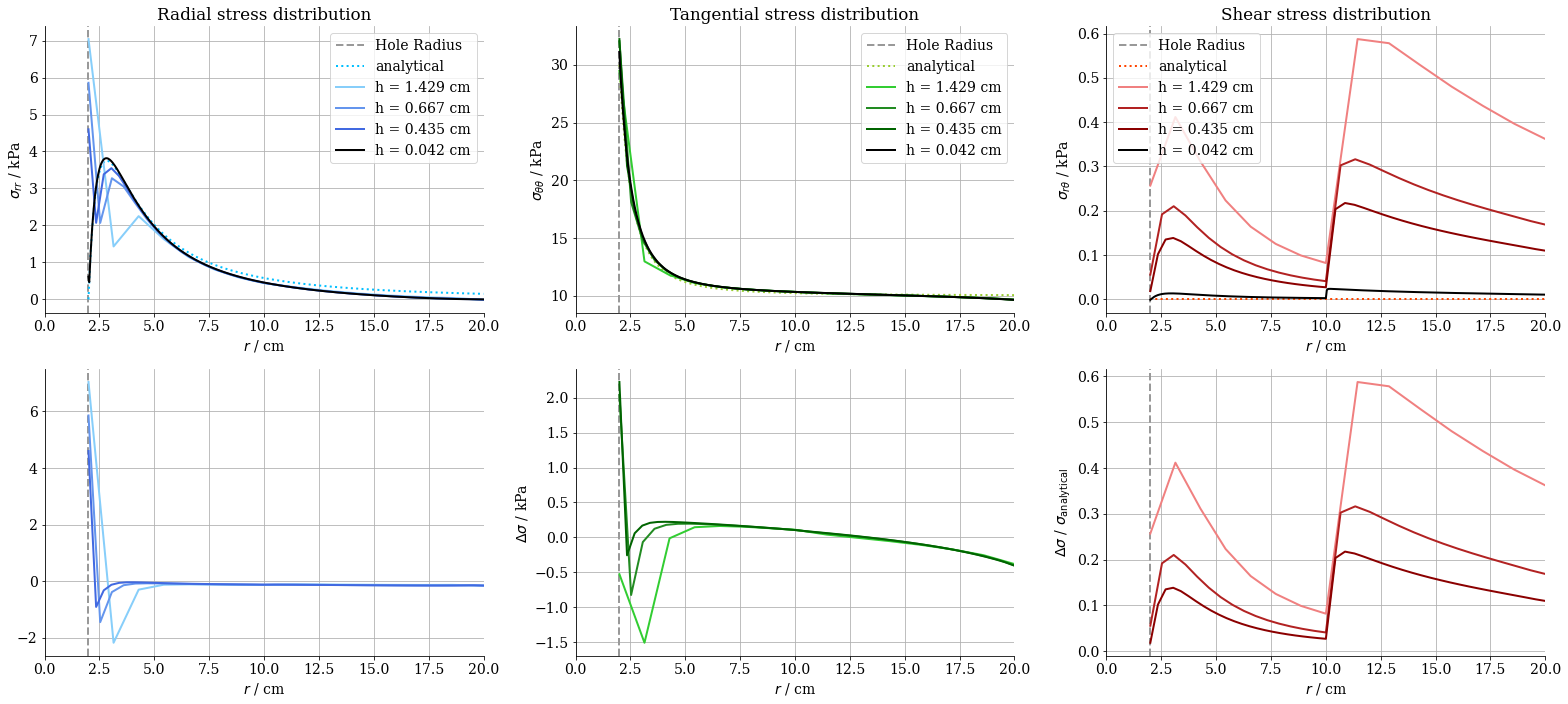

In [18]:
def plot_stress_distribution_along_xaxis():
    ### Step 1: Compute data ##########################################

    # These variables will hold the error data for all STUDY_indices
    f_abs_rr = {}
    f_abs_tt = {}
    f_abs_rt = {}

    # Plot setup
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 10))
    for i in range(2):
        for j in range(3):
            ax[i][j].axvline(2, color="0.6", linestyle="--", label="Hole Radius")
            ax[i][j].grid(True)
            ax[i][j].set(xlim=(0, STUDY_mesh_size))
            ax[i][j].set_xlabel("$r$ / cm")
            ax[i][1].set_ylabel("$\\Delta\\sigma$ / kPa")
            ax[i][2].set_ylabel("$\\Delta\\sigma$ / $\\sigma_{\\mathrm{analytical}}$")

    for iteration, idx in enumerate(STUDY_indices):
        # we use the line mesh we extracted before
        line_mesh = STUDY_num_result_xaxis_meshes_by_index[idx]

        sig_rr, sig_tt, sig_rt = get_sigma_polar_components(line_mesh)

        (
            indices_sorted,
            dist_sorted,
        ) = get_sort_indices_and_distances_by_distance_from_origin_2D(line_mesh)

        # sort sigma by distance from origin
        sig_rr_sorted = sig_rr[indices_sorted]
        sig_tt_sorted = sig_tt[indices_sorted]
        sig_rt_sorted = sig_rt[indices_sorted]

        # compute errors
        f_abs_rr, f_rel_rr = compute_abs_and_rel_stress_error_rr(
            sig_rr_sorted, dist_sorted, -90
        )
        f_abs_tt, f_rel_tt = compute_abs_and_rel_stress_error_tt(
            sig_tt_sorted, dist_sorted, -90
        )
        f_abs_rt, f_rel_rt = compute_abs_and_rel_stress_error_rt(
            sig_rt_sorted, dist_sorted, -90
        )

        ### Step 2: Plot data ##############################################

        ax[0][0].set_ylabel("$\\sigma_{rr}$ / kPa")
        ax[0][1].set_ylabel("$\\sigma_{\\theta\\theta}$ / kPa")
        ax[0][2].set_ylabel("$\\sigma_{r\\theta}$ / kPa")

        # analytical results
        if iteration == 0:
            r = np.linspace(2, STUDY_mesh_size, 1000)
            ax[0][0].plot(
                r,
                kirsch_sig_rr(10, r, -90, 2),
                color="deepskyblue",
                linestyle=":",
                label="analytical",
            )
            ax[0][1].plot(
                r,
                kirsch_sig_tt(10, r, -90, 2),
                color="yellowgreen",
                linestyle=":",
                label="analytical",
            )
            ax[0][2].plot(
                r,
                kirsch_sig_rt(10, r, -90, 2),
                color="orangered",
                linestyle=":",
                label="analytical",
            )

        # numerical results
        cell_size = compute_cell_size(idx, STUDY_num_result_meshes_by_index[idx])

        if idx == 8:
            ax[0][0].plot(
                dist_sorted,
                sig_rr_sorted * 1000,
                color="lightskyblue",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][1].plot(
                dist_sorted,
                sig_tt_sorted * 1000,
                color="limegreen",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][2].plot(
                dist_sorted,
                sig_rt_sorted * 1000,
                color="lightcoral",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[1][0].plot(dist_sorted, f_abs_rr, color="lightskyblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color="limegreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color="lightcoral")

        if idx == 16:
            ax[0][0].plot(
                dist_sorted,
                sig_rr_sorted * 1000,
                color="cornflowerblue",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][1].plot(
                dist_sorted,
                sig_tt_sorted * 1000,
                color="forestgreen",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][2].plot(
                dist_sorted,
                sig_rt_sorted * 1000,
                color="firebrick",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[1][0].plot(dist_sorted, f_abs_rr, color="cornflowerblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color="forestgreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color="firebrick")

        if idx == 24:
            ax[0][0].plot(
                dist_sorted,
                sig_rr_sorted * 1000,
                color="royalblue",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][1].plot(
                dist_sorted,
                sig_tt_sorted * 1000,
                color="darkgreen",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][2].plot(
                dist_sorted,
                sig_rt_sorted * 1000,
                color="darkred",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[1][0].plot(dist_sorted, f_abs_rr, color="royalblue")
            ax[1][1].plot(dist_sorted, f_abs_tt, color="darkgreen")
            ax[1][2].plot(dist_sorted, f_abs_rt, color="darkred")

        if idx == 240:
            ax[0][0].plot(
                dist_sorted,
                sig_rr_sorted * 1000,
                color="black",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][1].plot(
                dist_sorted,
                sig_tt_sorted * 1000,
                color="black",
                label=f"h = {cell_size:.3f} cm",
            )
            ax[0][2].plot(
                dist_sorted,
                sig_rt_sorted * 1000,
                color="black",
                label=f"h = {cell_size:.3f} cm",
            )

        # final plot settings
        for i in range(3):
            ax[0][i].legend()

        ax[0][0].set_title("Radial stress distribution")
        ax[0][1].set_title("Tangential stress distribution")
        ax[0][2].set_title("Shear stress distribution")

        fig.tight_layout()


plot_stress_distribution_along_xaxis()

## Comparison with "pseudo" analytical solution

As described before the numerical solutions for each refinement step are compared to the solution for the finest refinement index of 240 in the following section. Although the approximation is already clear from the previous plots of the stress curves along the x axis, mathematical norms are used hereafter for a better representation and interpretation of the relationship.
In particular, these norms reveal how fast the solution converges to the pseudo analytical one.

### Norm Plots

To quantify the total error of a numerical calculation, various error norms can be used:

\begin{align}
    \ell_{2}=|w|=\sqrt{\sum_{i=0}^N (w_{i})^2}
\\
    RMS =\sqrt{\frac{\sum_{i=0}^N (w_{i})^2}{N}}
\\
L_{2}=||w||=\sqrt{\int_{\Omega} (w(x))^2 dx}
\end{align}

The $\ell_{2}$ norm or Euclidean norm is the square root of the sum of the squared absolute errors at each point of the mesh.

The root mean square ($RMS$) is calculated similarly. Here, however, the influence of the number of points is taken into account by dividing by the square root of the number of points.

The $L_{2}$ norm as integral norm represents a generalization of the $\ell_{2}$ norm for continuous functions. While the Euclidean norm only considers the values on individual mesh nodes, the integral norm considers the solution on the entire mesh. Therefore an advantage of the $L_{2}$ norm is, that big elements are considered with a higher impact than small ones, which produces more homogeneous results.

The following plots represent the development of the Euclidean and Integral norm and $RMS$ for the refinement of the mesh. How fast the considered element converge is expressed by the slope of the lines in the plot.
First the detailed discussed error norms for the stresses are visualised and in addition to them the norms for the associated displacements to draw conclusions about the quality of convergence.

The main conclusion that can be drawn is that the solution for the displacements converge significantly faster than those for the stresses.
As a practical consequence, it might be possible to get a sufficiently accurate displacement solution already on a relatively coarse mesh,
whereas for an accurate stress solution a much finer mesh might be necessary.

In [19]:
from vtkmodules.vtkFiltersParallel import vtkIntegrateAttributes

In [20]:
def integrate_mesh_attributes(mesh):
    integrator = vtkIntegrateAttributes()
    integrator.SetInputData(mesh)
    integrator.Update()
    return pv.wrap(
        integrator.GetOutputDataObject(0)
    )  # that is an entire mesh with one point and one cell

In [21]:
def compute_ell_2_norm_sigma(_idx, sigmas_test, sigmas_reference):
    sig_rr, sig_tt, sig_rt = sigmas_test
    sig_rr_240, sig_tt_240, sig_rt_240 = sigmas_reference

    list_rr = (sig_rr_240 - sig_rr) ** 2
    list_tt = (sig_tt_240 - sig_tt) ** 2
    list_rt = (sig_rt_240 - sig_rt) ** 2

    l2_rr = np.sqrt(sum(list_rr))
    l2_tt = np.sqrt(sum(list_tt))
    l2_rt = np.sqrt(sum(list_rt))

    return l2_rr, l2_tt, l2_rt

In [22]:
def compute_ell_2_norm_displacement(_idx, mesh_resampled_to_240_resolution, mesh_fine):
    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:, 0]
    dis_y = dis[:, 1]

    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:, 0]
    dis_y_240 = dis_240[:, 1]

    list_x = (dis_x_240 - dis_x) ** 2
    list_y = (dis_y_240 - dis_y) ** 2

    l2_x = np.sqrt(sum(list_x))
    l2_y = np.sqrt(sum(list_y))

    return l2_x, l2_y

In [23]:
def compute_root_mean_square_sigma(_idx, sigmas_test, sigmas_reference):
    sig_rr, sig_tt, sig_rt = sigmas_test
    sig_rr_240, sig_tt_240, sig_rt_240 = sigmas_reference

    l2_rr = np.linalg.norm(sig_rr_240 - sig_rr)
    l2_tt = np.linalg.norm(sig_tt_240 - sig_tt)
    l2_rt = np.linalg.norm(sig_rt_240 - sig_rt)

    points = sig_rr.shape[0]
    return l2_rr / np.sqrt(points), l2_tt / np.sqrt(points), l2_rt / np.sqrt(points)

In [24]:
def compute_root_mean_square_displacement(
    _idx, mesh_resampled_to_240_resolution, mesh_fine
):
    points = mesh_resampled_to_240_resolution.point_data["sigma"].shape[0]

    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:, 0]
    dis_y = dis[:, 1]

    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:, 0]
    dis_y_240 = dis_240[:, 1]

    l2_x = np.linalg.norm(dis_x_240 - dis_x)
    l2_y = np.linalg.norm(dis_y_240 - dis_y)

    return l2_x / np.sqrt(points), l2_y / np.sqrt(points)

In [25]:
def compute_Ell_2_norm_sigma(
    _idx, mesh_resampled_to_240_resolution, sigmas_test, sigmas_reference
):
    sig_rr, sig_tt, sig_rt = sigmas_test
    sig_rr_240, sig_tt_240, sig_rt_240 = sigmas_reference

    list_rr = (sig_rr_240 - sig_rr) ** 2
    list_tt = (sig_tt_240 - sig_tt) ** 2
    list_rt = (sig_rt_240 - sig_rt) ** 2

    # We add the squared differences as new point data to the mesh
    mesh_resampled_to_240_resolution.point_data["diff_rr_squared"] = list_rr
    mesh_resampled_to_240_resolution.point_data["diff_tt_squared"] = list_tt
    mesh_resampled_to_240_resolution.point_data["diff_rt_squared"] = list_rt

    # this will integrate all fields at once, so you can add the tt and rt components above and call this only once.
    integration_result_mesh = integrate_mesh_attributes(
        mesh_resampled_to_240_resolution
    )

    # new: integral norm, the index [0] accesses the data of the single point contained in the mesh
    L2_rr = np.sqrt(integration_result_mesh.point_data["diff_rr_squared"][0])
    L2_tt = np.sqrt(integration_result_mesh.point_data["diff_tt_squared"][0])
    L2_rt = np.sqrt(integration_result_mesh.point_data["diff_rt_squared"][0])

    return L2_rr, L2_tt, L2_rt

In [26]:
def compute_Ell_2_norm_displacement(_idx, mesh_resampled_to_240_resolution, mesh_fine):
    dis = mesh_resampled_to_240_resolution.point_data["displacement"]
    dis_x = dis[:, 0]
    dis_y = dis[:, 1]

    dis_240 = mesh_fine.point_data["displacement"]
    dis_x_240 = dis_240[:, 0]
    dis_y_240 = dis_240[:, 1]

    list_x = (dis_x_240 - dis_x) ** 2
    list_y = (dis_y_240 - dis_y) ** 2

    # We add the squared differences as new point data to the mesh
    mesh_resampled_to_240_resolution.point_data["diff_x_squared"] = list_x
    mesh_resampled_to_240_resolution.point_data["diff_y_squared"] = list_y

    # this will integrate all fields at once, so you can add the tt and rt components above and call this only once.
    integration_result_mesh = integrate_mesh_attributes(
        mesh_resampled_to_240_resolution
    )

    # new: integral norm, the index [0] accesses the data of the single point contained in the mesh
    L2_x = np.sqrt(integration_result_mesh.point_data["diff_x_squared"][0])
    L2_y = np.sqrt(integration_result_mesh.point_data["diff_y_squared"][0])

    return L2_x, L2_y

In [27]:
# empty dictionaries
size = {}
l2_rr = {}
l2_tt = {}
l2_rt = {}
rms_rr = {}
rms_tt = {}
rms_rt = {}
L2_rr = {}
L2_tt = {}
L2_rt = {}
l2_x = {}
l2_y = {}
rms_x = {}
rms_y = {}
L2_x = {}
L2_y = {}


def compute_error_norms():
    mesh_fine = STUDY_num_result_meshes_by_index[240]
    sigmas_reference = get_sigma_polar_components(mesh_fine)

    for idx in STUDY_indices:
        if idx != 240:  # 240 is the "pseudo" analytical solution we compare against.
            mesh_coarse = STUDY_num_result_meshes_by_index[idx]
            mesh_resampled_to_240_resolution = mesh_fine.sample(mesh_coarse)
            sigmas_test = get_sigma_polar_components(mesh_resampled_to_240_resolution)

            l2_rr[idx], l2_tt[idx], l2_rt[idx] = compute_ell_2_norm_sigma(
                idx, sigmas_test, sigmas_reference
            )
            rms_rr[idx], rms_tt[idx], rms_rt[idx] = compute_root_mean_square_sigma(
                idx, sigmas_test, sigmas_reference
            )
            L2_rr[idx], L2_tt[idx], L2_rt[idx] = compute_Ell_2_norm_sigma(
                idx, mesh_resampled_to_240_resolution, sigmas_test, sigmas_reference
            )

            l2_x[idx], l2_y[idx] = compute_ell_2_norm_displacement(
                idx, mesh_resampled_to_240_resolution, mesh_fine
            )
            rms_x[idx], rms_y[idx] = compute_root_mean_square_displacement(
                idx, mesh_resampled_to_240_resolution, mesh_fine
            )
            L2_x[idx], L2_y[idx] = compute_Ell_2_norm_displacement(
                idx, mesh_resampled_to_240_resolution, mesh_fine
            )
            size[idx] = compute_cell_size(idx, mesh_coarse)


compute_error_norms()

In [28]:
def plot_slope_sketch(ax, x0, y0, slopes, xmax=None):
    """Plot sketch for slopes. All slopes cross at (x0, y0)"""
    if xmax is None:
        xmax = 2 * x0
    xs = np.linspace(x0, xmax, 20)

    for slope in slopes:
        y_ = xs[0] ** slope
        ys = y0 / y_ * xs**slope
        ax.plot(xs, ys, color="black")
        ax.text(xs[-1] * 1.05, ys[-1], slope)

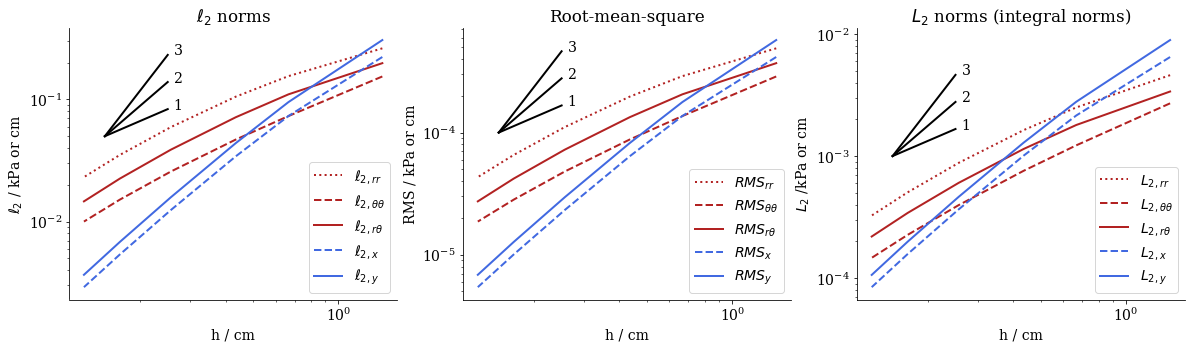

In [29]:
h = np.linspace(size[80], size[8], 1000)
k = np.linspace(1, 2, 20)

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(
    size.values(),
    l2_rr.values(),
    color="firebrick",
    linestyle=":",
    label=r"$\ell_{2, rr}$",
)
ax[0].plot(
    size.values(),
    l2_tt.values(),
    color="firebrick",
    linestyle="--",
    label="$\\ell_{2, \\theta\\theta}$",
)
ax[0].plot(
    size.values(), l2_rt.values(), color="firebrick", label="$\\ell_{2, r\\theta}$"
)
ax[0].plot(
    size.values(),
    l2_x.values(),
    color="royalblue",
    linestyle="--",
    label=r"$\ell_{2, x}$",
)
ax[0].plot(size.values(), l2_y.values(), color="royalblue", label=r"$\ell_{2, y}$")

plot_slope_sketch(ax[0], 1.5e-1, 5e-2, [1, 2, 3], xmax=2.5e-1)

ax[0].set_title(r"$\ell_2$ norms")
ax[0].set_ylabel(r"$\ell_2$ / kPa or cm")

ax[1].plot(
    size.values(), rms_rr.values(), color="firebrick", linestyle=":", label="$RMS_{rr}$"
)
ax[1].plot(
    size.values(),
    rms_tt.values(),
    color="firebrick",
    linestyle="--",
    label="$RMS_{\\theta\\theta}$",
)
ax[1].plot(size.values(), rms_rt.values(), color="firebrick", label="$RMS_{r\\theta}$")
ax[1].plot(
    size.values(), rms_x.values(), color="royalblue", linestyle="--", label="$RMS_{x}$"
)
ax[1].plot(size.values(), rms_y.values(), color="royalblue", label="$RMS_{y}$")

plot_slope_sketch(ax[1], 1.5e-1, 1e-4, [1, 2, 3], xmax=2.5e-1)

ax[1].set_title("Root-mean-square")
ax[1].set_ylabel("RMS / kPa or cm")

ax[2].plot(
    size.values(), L2_rr.values(), color="firebrick", linestyle=":", label="$L_{2, rr}$"
)
ax[2].plot(
    size.values(),
    L2_tt.values(),
    color="firebrick",
    linestyle="--",
    label="$L_{2, \\theta\\theta}$",
)
ax[2].plot(size.values(), L2_rt.values(), color="firebrick", label="$L_{2, r\\theta}$")
ax[2].plot(
    size.values(), L2_x.values(), color="royalblue", linestyle="--", label="$L_{2, x}$"
)
ax[2].plot(size.values(), L2_y.values(), color="royalblue", label="$L_{2, y}$")

plot_slope_sketch(ax[2], 1.5e-1, 1e-3, [1, 2, 3], xmax=2.5e-1)

ax[2].set_title("$L_2$ norms (integral norms)")
ax[2].set_ylabel("$L_2$ /kPa or cm")
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("h / cm")
    ax[i].loglog(base=10)